# grn bench perturb seq


In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_perturb_gt

from bengrn.base import train_classifier

from bengrn import compute_genie3, compute_scenic
from grnndata import utils as grnutils

import scanpy as sc

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
2024-05-28 15:54:43,934:INFO - Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2024-05-28 15:54:43,987:INFO - Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2024-05-28 15:54:44,059:INFO - Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2024-05-28 15:54:44,133:INFO - Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2024-05-28 15:54:44,217:INFO - Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2024-05-28 15:54:44,373:INFO - Downloading data from `https://omnipathdb.org/about?format=text`
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core

In [2]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(grnutils.TF), "isTF"] = True
adata.var["isTF"].sum()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/gem_group' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/gene' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Ele

650

In [3]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = preprocessor(adata.copy())
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts


removed 0 non primary cells, 10691 renamining
filtered out 0 cells, 10691 renamining
Removed 8 genes.
startin QC
Seeing 10068 outliers (94.17% of total dataset):
done


GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

In [4]:
model = scPrint.load_from_checkpoint(
    '../data/temp/wli32e2j/last.ckpt', precpt_gene_emb=None)

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [8]:
model = scPrint.load_from_checkpoint(
    '../data/temp/25eer0xz/epoch=20-step=105000.ckpt', precpt_gene_emb=None)

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [4]:
model = scPrint.load_from_checkpoint(
    '../data/temp/vbd8bavn/epoch=17-step=90000.ckpt', precpt_gene_emb=None)

RuntimeError caught: scPrint is not attached to a `Trainer`.



/tmp/ipykernel_2262247/3144382640.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 8555


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical
/home/ml4ig1/Documents code/benGRN/bengrn/base.py:278: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 11622 ...
doing regression....
metrics {'used_heads': 19, 'precision': 0.007272727272727273, 'random_precision': 0.0017514728633597546, 'recall': 0.008517887563884156, 'predicted_true': 1375.0, 'number_of_true': 1174.0, 'epr': 3.4332195942547448}


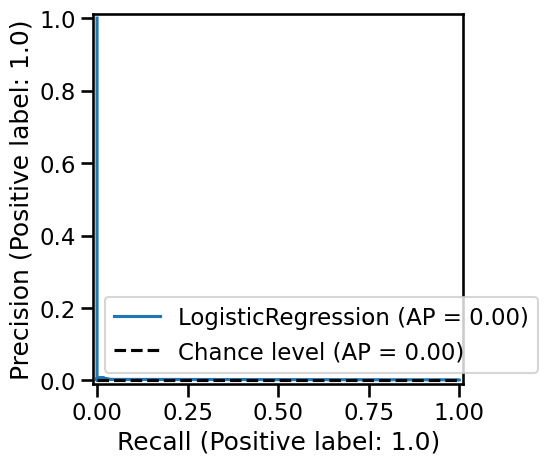

base enrichment
Top central genes: []


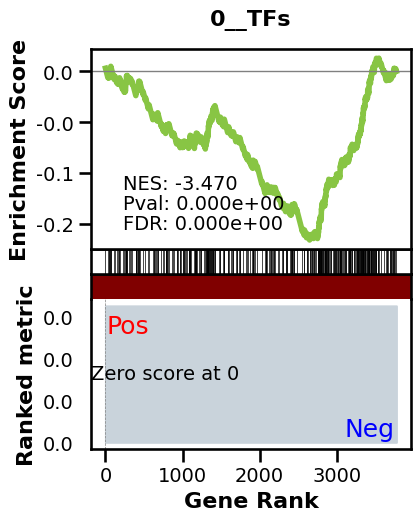

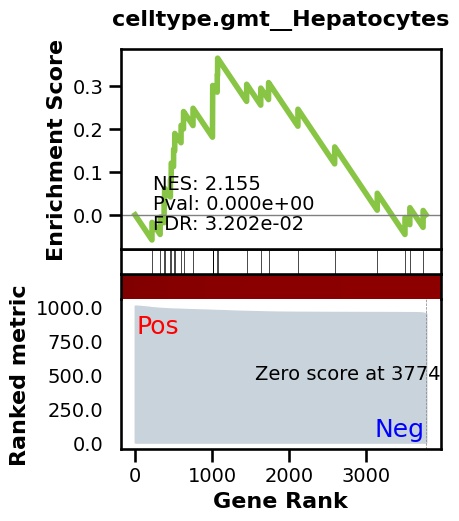

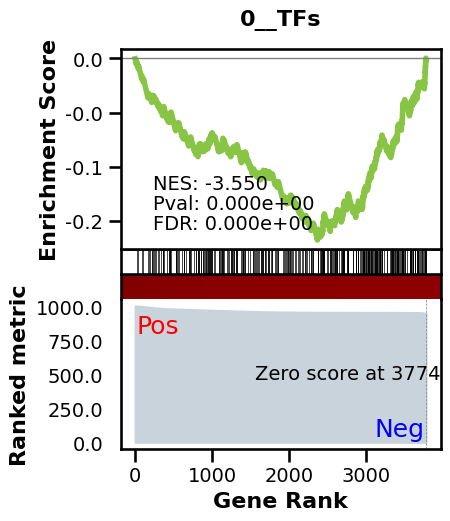

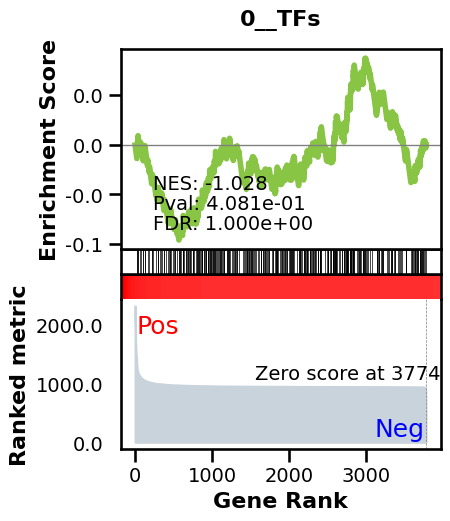

_________________________________________
TF specific enrichment


2024-05-27 13:00:54,061:INFO - Downloading and generating Enrichr library gene sets...
2024-05-27 13:00:54,065:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-27 13:00:54,306:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  22.641509433962263 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2637 genes
intersection pct: 0.6978036517597248
precision:  0.00171000791081786 
recall:  1.0 
random precision: 0.0017106566239858487


 95%|█████████▍| 94/99 [00:01<00:00, 78.32it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:684: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 72.58it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0024080601078044733
EPR: 3.7715340731323233


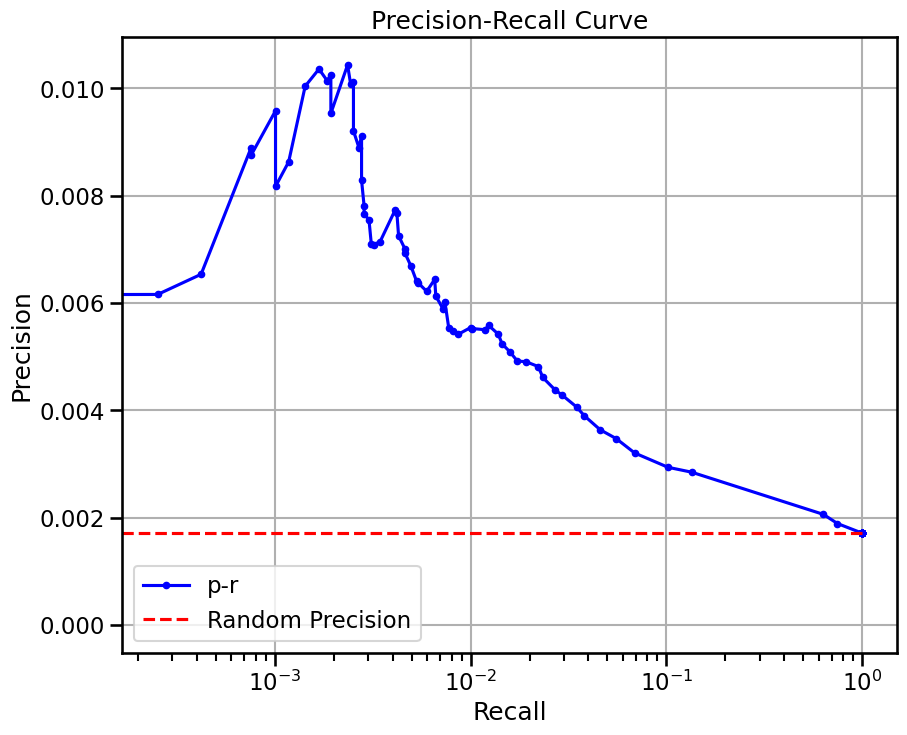

{'TF_enr': True,
 'enriched_terms_Targets': ['celltype.gmt__Hepatocytes',
  'celltype.gmt__Embryonic stem cells',
  'celltype.gmt__Radial glial cells',
  'celltype.gmt__Pancreatic stellate cells',
  'celltype.gmt__Microfold cells',
  'celltype.gmt__Ductal cells'],
 'significant_enriched_TFtargets': 22.641509433962263,
 'precision': 0.00171000791081786,
 'recall': 1.0,
 'rand_precision': 0.0017106566239858487,
 'auprc': 0.0024080601078044733,
 'EPR': 3.7715340731323233}

In [5]:
grn_inferer = GRNfer(model, nadata[nadata.X.sum(1) > 500],
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     num_genes=4000,
                     max_cells=2048,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True, use_col="gene_name")
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

base enrichment
Top central genes: []


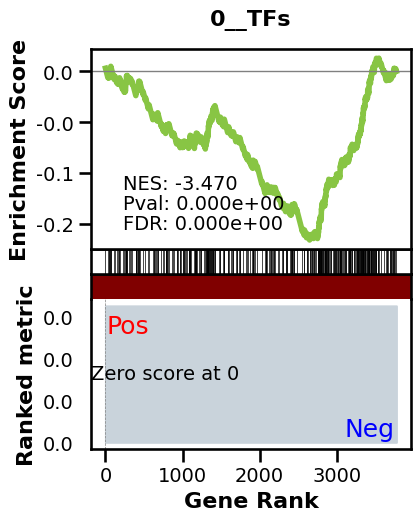

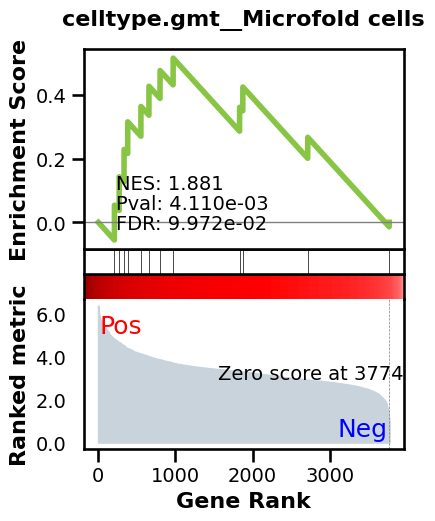

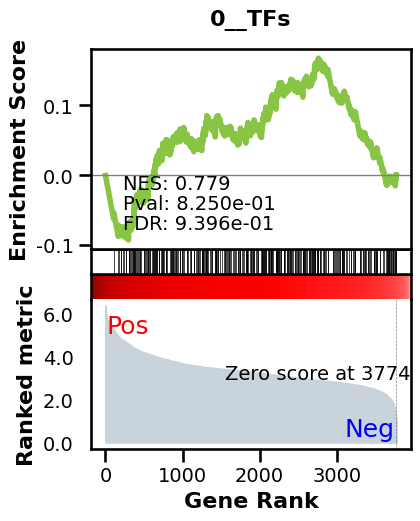

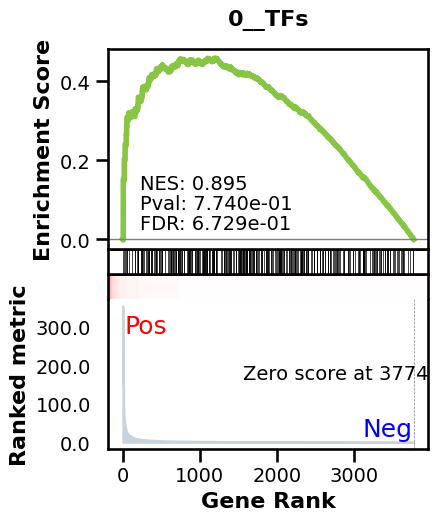

_________________________________________
TF specific enrichment
found some significant results for  11.320754716981131 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2637 genes
intersection pct: 0.6978036517597248
precision:  0.00171000791081786 
recall:  1.0 
random precision: 0.0017106566239858487


 89%|████████▉ | 88/99 [00:00<00:00, 95.07it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:684: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 92.12it/s]


Area Under Precision-Recall Curve (AUPRC):  0.002045814582635471
EPR: 2.0723144494659893


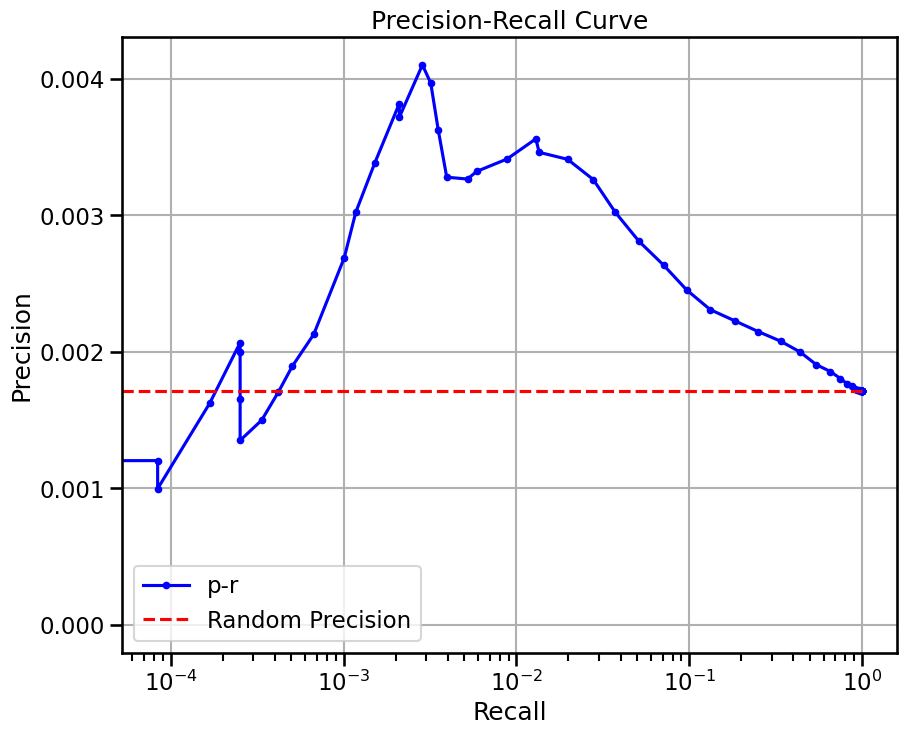

{'TF_enr': True,
 'enriched_terms_Targets': ['celltype.gmt__Microfold cells'],
 'significant_enriched_TFtargets': 11.320754716981131,
 'precision': 0.00171000791081786,
 'recall': 1.0,
 'rand_precision': 0.0017106566239858487,
 'auprc': 0.002045814582635471,
 'EPR': 2.0723144494659893}

In [14]:
#grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.02194688832228094 
recall:  1.0 
random precision: 0.021952697451005733


 96%|█████████▌| 95/99 [00:02<00:00, 43.77it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:02<00:00, 39.01it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03449732872210877
EPR: 2.0587397220894985


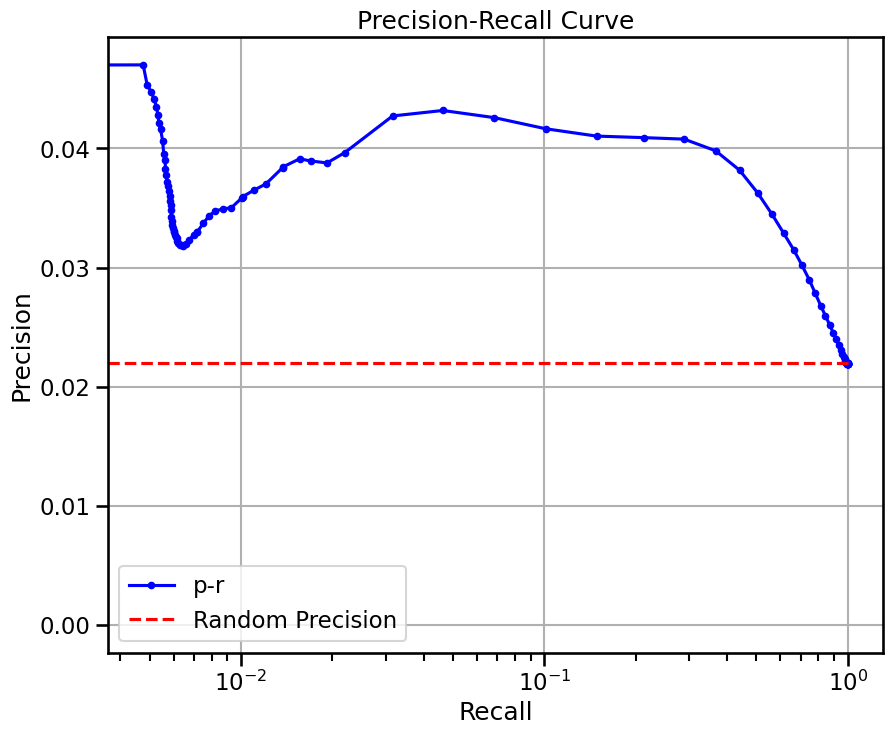

{'precision': 0.02194688832228094,
 'recall': 1.0,
 'rand_precision': 0.021952697451005733,
 'auprc': 0.03449732872210877,
 'EPR': 2.0587397220894985}

In [6]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [6]:
grn_inferer = GRNfer(model, nadata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     num_genes=4000,
                     max_cells=2048,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

/tmp/ipykernel_1549667/496965529.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 8555


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


In [9]:
grn.var['ensembl_id'] = grn.var.index
grn.varp['GRN'] = grn.varp['all']
grn, m, clf = train_classifier(grn, other=adata, C=0.8, train_size=0.5, class_weight={
                               1: 30, 0: 1}, shuffle=False, use_col="ensembl_id")
grn.varp['GRN'] = grn.varp['classified']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

pred shape (2392, 3779, 96)
true elem 198386 ...
doing regression....
metrics {'used_heads': 71, 'precision': 0.1119519730924166, 'random_precision': 0.02234479715555353, 'recall': 0.040491413698475115, 'predicted_true': 51138, 'number_of_true': 141388, 'epr': 4.393100185729834}


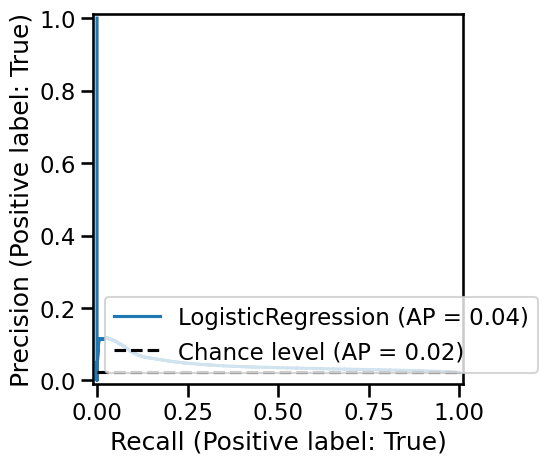

precision:  0.02194688832228094 
recall:  1.0 
random precision: 0.021952697451005733


 95%|█████████▍| 94/99 [00:04<00:00, 31.13it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:04<00:00, 21.41it/s]


Area Under Precision-Recall Curve (AUPRC):  0.046943676532538225
EPR: 4.326538348561062


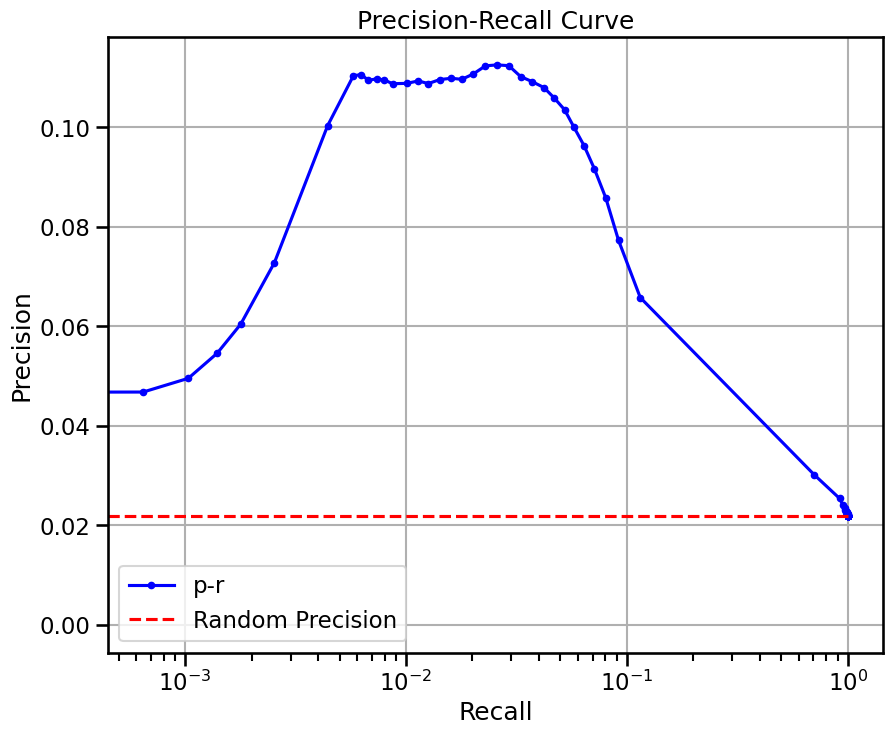

{'precision': 0.02194688832228094,
 'recall': 1.0,
 'rand_precision': 0.021952697451005733,
 'auprc': 0.046943676532538225,
 'EPR': 4.326538348561062}

In [8]:
grn.var['ensembl_id'] = grn.var.index
grn.varp['all'] = grn.varp['GRN']
grn, m, clf = train_classifier(grn, other=adata, C=0.3, train_size=0.3, class_weight={
                               1: 40, 0: 1}, shuffle=False, use_col="ensembl_id")
grn.varp['GRN'] = grn.varp['classified']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [ ]:
import joblib

joblib.dump(clf, '/tmp/classifier.pkl')

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:270: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 11622 ...
doing regression....
metrics {'used_heads': 74, 'precision': 0.007114905727499111, 'random_precision': 0.0017514728633597546, 'recall': 0.017035775127768313, 'predicted_true': 2811.0, 'number_of_true': 1174.0, 'epr': 6.442108996001991}


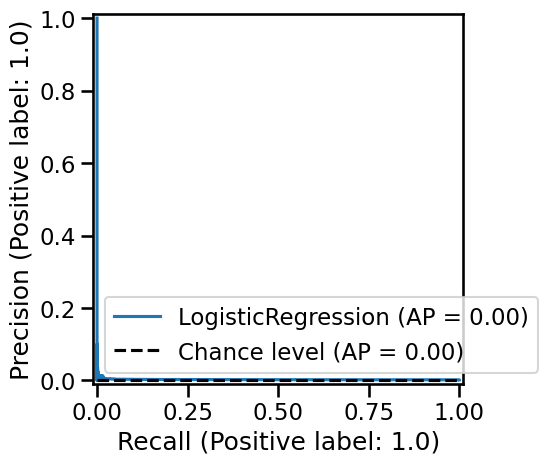

precision:  0.02194688832228094 
recall:  1.0 
random precision: 0.021952697451005733


 96%|█████████▌| 95/99 [00:04<00:00, 26.84it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:04<00:00, 23.06it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03501631269371136
EPR: 2.482294191417132


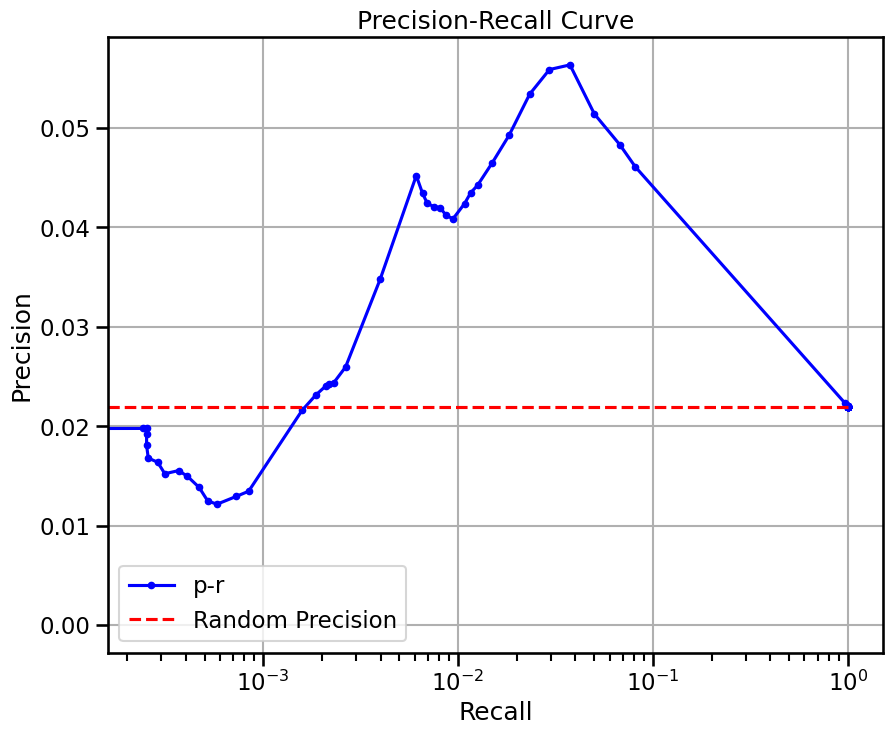

{'precision': 0.02194688832228094,
 'recall': 1.0,
 'rand_precision': 0.021952697451005733,
 'auprc': 0.03501631269371136,
 'EPR': 2.482294191417132}

In [8]:
grn.varp['GRN'] = grn.varp['all']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True, use_col="gene_name")
grn.varp['GRN'] = grn.varp['classified']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

# no class

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 8555


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 14341369, sparsity: 1.0


... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.02194688832228094 
recall:  1.0 
random precision: 0.021952697451005733


 97%|█████████▋| 96/99 [00:04<00:00, 21.83it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:693: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:04<00:00, 22.52it/s]


Area Under Precision-Recall Curve (AUPRC):  0.031131338909927447
EPR: 2.7013433639995794


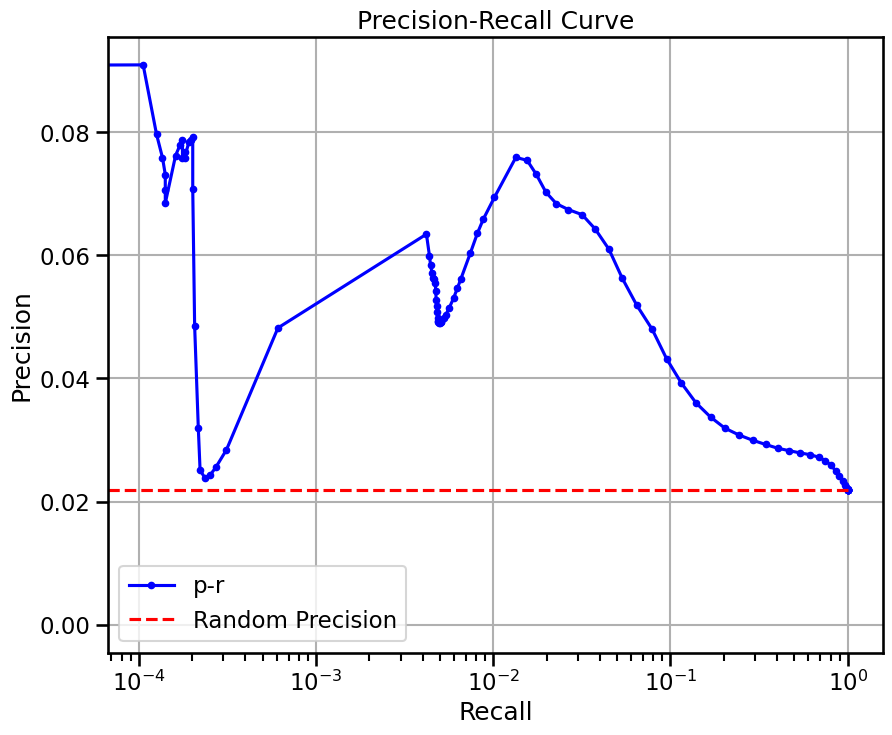

{'precision': 0.02194688832228094,
 'recall': 1.0,
 'rand_precision': 0.021952697451005733,
 'auprc': 0.031131338909927447,
 'epr': 2.7013433639995794}

In [12]:
grn_inferer = GRNfer(model, nadata[nadata.X.sum(1) > 500],
                     how="most var within",
                     preprocess="softmax",
                     head_agg='mean',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     num_genes=4000,
                     max_cells=2048,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[10:])
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [ ]:
adata.var

# GENIE3

In [15]:
NUM_GENES = 4000
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['symbol'] = adata.var["gene_name"]
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:1024, adata.var.index.isin(
    grn_inferer.model.genes) & adata.var.highly_variable]

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 285.71 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


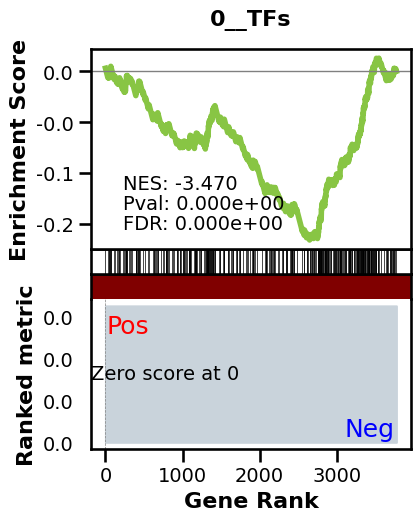

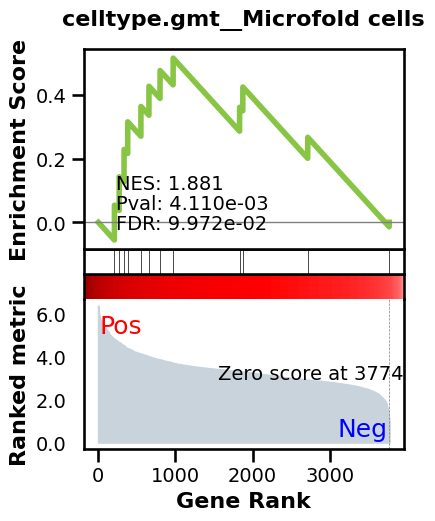

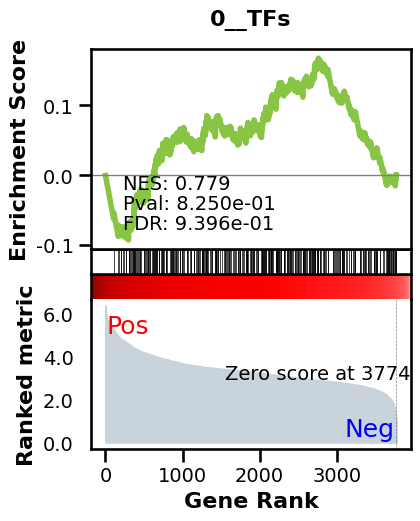

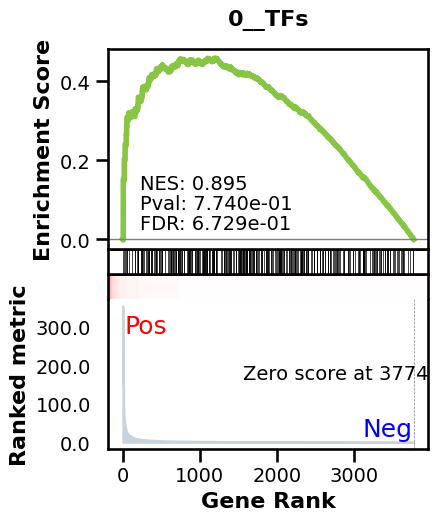

_________________________________________
TF specific enrichment
found some significant results for  11.320754716981131 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2637 genes
intersection pct: 0.6978036517597248
precision:  0.00171000791081786 
recall:  1.0 
random precision: 0.0017106566239858487


 98%|█████████▊| 97/99 [00:01<00:00, 89.16it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:684: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 85.91it/s]


Area Under Precision-Recall Curve (AUPRC):  0.002045814582635471
EPR: 2.0723144494659893


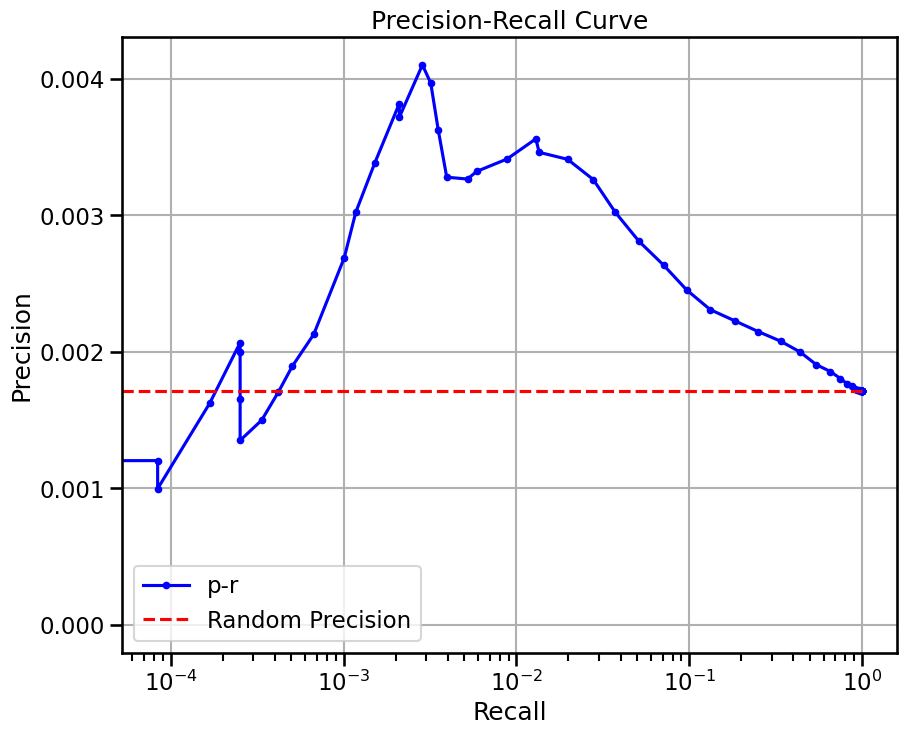

{'TF_enr': True,
 'enriched_terms_Targets': ['celltype.gmt__Microfold cells'],
 'significant_enriched_TFtargets': 11.320754716981131,
 'precision': 0.00171000791081786,
 'recall': 1.0,
 'rand_precision': 0.0017106566239858487,
 'auprc': 0.002045814582635471,
 'EPR': 2.0723144494659893}

In [17]:
genie_grn = compute_genie3(subadata, nthreads=32)
genie_grn.var.index = subadata.var.index
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.016276152930373752 
recall:  0.05667456755257451 
random precision: 0.021980341289997398


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:665: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 45%|████▌     | 45/99 [00:01<00:01, 34.80it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:671: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:03<00:00, 31.90it/s]


Area Under Precision-Recall Curve (AUPRC):  0.01941189067348338
EPR: 1.0479563381190067


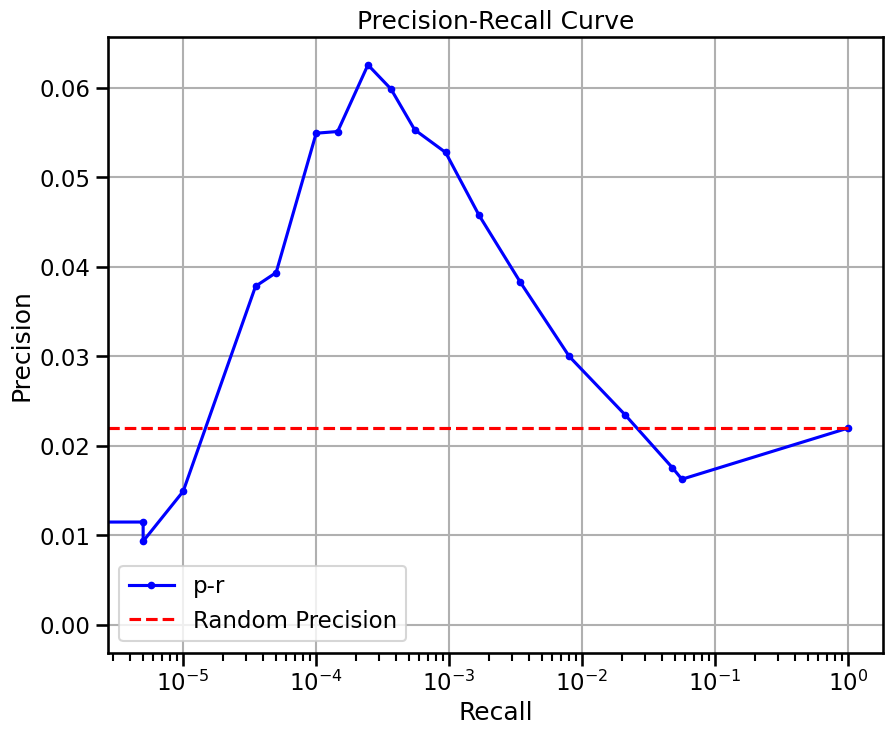

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 278.26 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


da is very small:  0


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:641: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] != 0).sum() / (grn != 0).sum()
/home/ml4ig1/Documents code/benGRN/bengrn/base.py:642: RuntimeWarning: invalid value encountered in long_scalars
  recall = (grn[true] != 0).sum() / true.sum()
/home/ml4ig1/Documents code/benGRN/bengrn/base.py:643: RuntimeWarning: invalid value encountered in long_scalars
  rand_prec = true.sum() / tot


precision:  nan 
recall:  nan 
random precision: nan


ValueError: zero-size array to reduction operation minimum which has no identity

In [35]:
genie_grn = compute_genie3(subadata, nthreads=32,
                           regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var.index = subadata.var.index
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)
genie_grn = compute_genie3(subadata, nthreads=32)
genie_grn.var.index = subadata.var.index
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

precision:  0.022319271167928253 
recall:  0.9759191083766201 
random precision: 0.021980341289997398


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:665: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 47%|████▋     | 47/99 [00:01<00:01, 35.45it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:671: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:03<00:00, 31.47it/s]


Area Under Precision-Recall Curve (AUPRC):  0.04526713524429972
EPR: 3.485497854493259


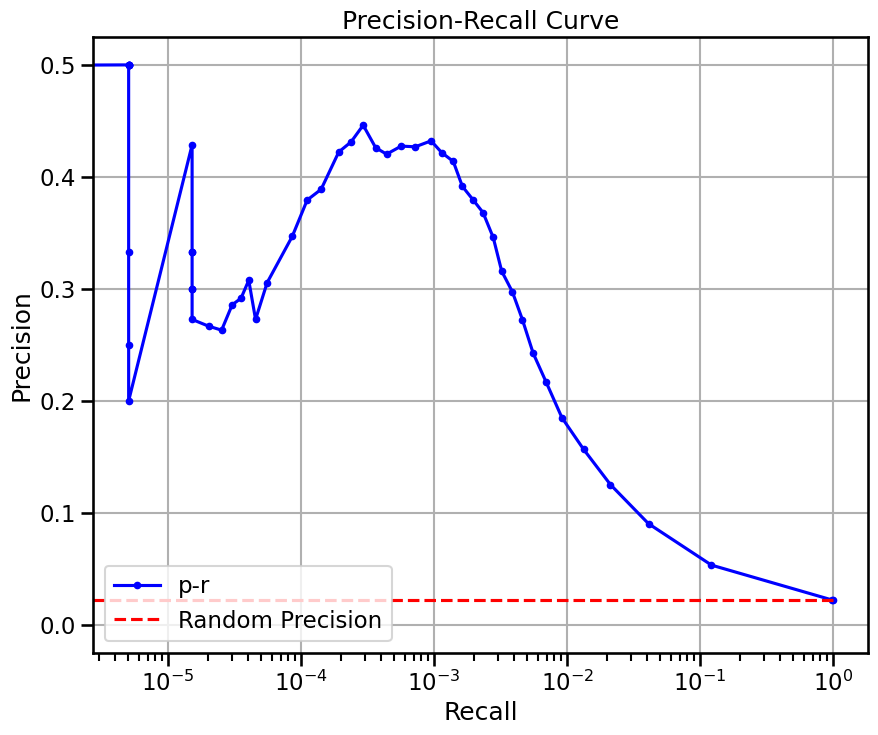

{'precision': 0.022319271167928253,
 'recall': 0.9759191083766201,
 'rand_precision': 0.021980341289997398,
 'auprc': 0.04526713524429972,
 'EPR': 3.485497854493259}

In [47]:
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)